# Analysis

In [1]:
import os
import json
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import soundfile as sf
from IPython.display import display, Audio

## Metadata

In [2]:
metadata = pd.read_csv('../data/binaural_musdb18/metadata.csv', index_col=0)

In [3]:
STEMS = ['bass', 'drums', 'other', 'vocals']
DATASETS = ['binaural', 'stereo']
MODELS = ['htdemucs', 'spleeter', 'umxhq']

## Plotting Parameters

In [4]:
PLOT_DIR = '../data/plots'

In [5]:
plt.style.use('petroff10') # 'tableau-colorblind10'

In [6]:
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [7]:
DATASET_PALETTE = dict(zip(DATASETS, COLORS[:3]))
STEM_PALETTE = dict(zip(STEMS, COLORS[3:7]))
MODEL_PALETTE = dict(zip(MODELS, COLORS[7:]))

## SPAUQ: Spatial Audio Quality Evaluation

In [8]:
OUTLIERS = False
FIG_SIZE = (6, 3)

### Data

In [9]:
ht_random_df = pd.read_csv('../data/eval/spauq/spauq_median_2025-03-23_htdemucs_ft_random.csv')
ht_stereo_df = pd.read_csv('../data/eval/spauq/spauq_median_2025-03-23_htdemucs_ft_stereo.csv')

spleet_random_df = pd.read_csv('../data/eval/spauq/spauq_2025-03-26_spleeter_test_random.csv')
spleet_stereo_df = pd.read_csv('../data/eval/spauq/spauq_2025-03-26_spleeter_test_stereo.csv')

umx_random_df = pd.read_csv('../data/eval/spauq/spauq_median_2025-03-24_umxhq_random.csv')
umx_stereo_df = pd.read_csv('../data/eval/spauq/spauq_median_2025-03-23_umxhq_stereo.csv')

In [10]:
ht_random_df['dataset'] = 'htdemucs_binaural'
ht_stereo_df['dataset'] = 'htdemucs_stereo'

spleet_random_df['dataset'] = 'spleeter_binaural'
spleet_stereo_df['dataset'] = 'spleeter_stereo'

umx_random_df['dataset'] = 'umxhq_binaural'
umx_stereo_df['dataset'] = 'umxhq_stereo'

In [11]:
htdemucs_df = pd.concat([ht_random_df, ht_stereo_df], ignore_index=True)
spleet_df = pd.concat([spleet_random_df, spleet_stereo_df], ignore_index=True)
umx_df = pd.concat([umx_random_df, umx_stereo_df], ignore_index=True)

In [12]:
all_models = pd.concat([htdemucs_df, spleet_df, umx_df], ignore_index=True)

### By Model (Overall)

In [13]:
all_models['model'] = all_models['dataset'].apply(lambda x: x.split('_')[0])
all_models['dataset'] = all_models['dataset'].apply(lambda x: x.split('_')[-1])

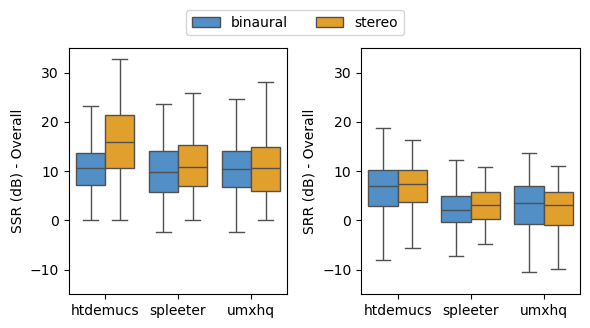

In [14]:
fig, axs = plt.subplots(1, 2, figsize=FIG_SIZE, tight_layout=True)
sns.boxplot(x='model', y='SSR', hue='dataset', data=all_models, ax=axs[0], palette=DATASET_PALETTE, showfliers=OUTLIERS)
sns.boxplot(x='model', y='SRR', hue='dataset', data=all_models, ax=axs[1], palette=DATASET_PALETTE, showfliers=OUTLIERS)

axs[0].set(ylabel='SSR (dB) - Overall', xlabel='', ylim=[-15, 35])
axs[1].set(ylabel='SRR (dB) - Overall', xlabel='', ylim=[-15, 35])

h, l = axs[0].get_legend_handles_labels()
l = ['binaural', 'stereo']

for a in axs:
    a.legend().remove()

fig.legend(h, l, loc='upper center', fontsize=10, ncols=3, bbox_to_anchor=(0.5, 1.1))
plt.savefig(os.path.join(PLOT_DIR, 'spauq_model_overall.pdf'), bbox_inches='tight')
plt.show()

### By Model (By Source)

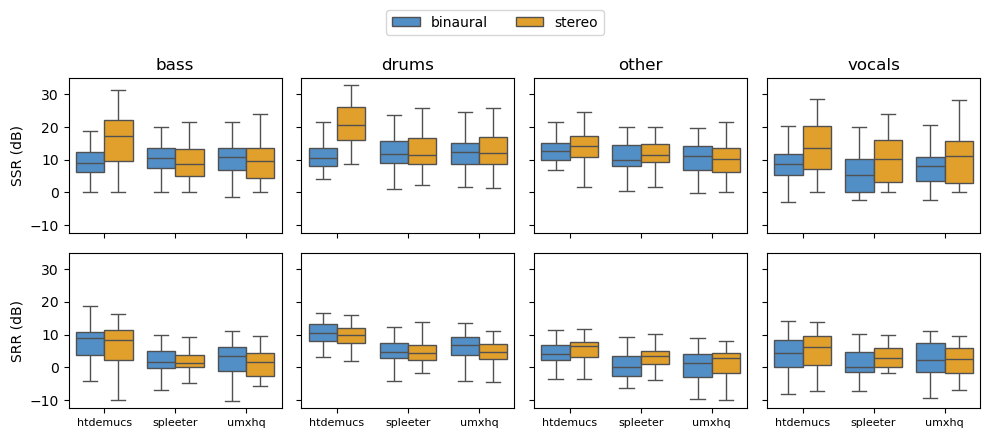

In [15]:
fig, axs = plt.subplots(2, 4, figsize=(10, 4), tight_layout=True, sharex=True, sharey=True)

x_labels = ['htdemucs', 'spleeter', 'umxhq']

for i in range(len(STEMS)):
    stem_df = all_models[all_models['source'] == STEMS[i]]
    
    sns.boxplot(x='model', y='SSR', hue='dataset', data=stem_df, ax=axs[0][i], palette=DATASET_PALETTE, showfliers=OUTLIERS)
    sns.boxplot(x='model', y='SRR', hue='dataset', data=stem_df, ax=axs[1][i], palette=DATASET_PALETTE, showfliers=OUTLIERS)
    
    axs[0][i].set(ylabel='SSR (dB)', xlabel='')
    axs[1][i].set(ylabel='SRR (dB)', xlabel='')
    axs[0][i].set_title(STEMS[i])

    axs[1][i].set_xticks(x_labels)
    axs[1][i].set_xticklabels(x_labels, fontsize=8)

h, l = axs[0][0].get_legend_handles_labels()
l = ['binaural', 'stereo']

for ax in axs.flatten():
    ax.legend().remove()

fig.legend(h, l, loc='upper center', fontsize=10, ncols=3, bbox_to_anchor=(0.5, 1.1))
plt.savefig(os.path.join(PLOT_DIR, 'spauq_model_source.pdf'), bbox_inches='tight')
plt.show()

### Angle Bins

In [16]:
OUTLIERS = False
FIG_SIZE = (6, 4)

In [17]:
metadata = pd.read_csv('../data/binaural_musdb18/metadata.csv', index_col=0)
metadata.rename(columns={'standard_angle': 'standard', 'random_angle': 'binaural'}, inplace=True)
metadata = metadata.melt(id_vars=['title', 'source'], var_name='dataset', value_name='angle')

In [18]:
merged_df = pd.merge(metadata, all_models, how='inner')
b = np.arange(-90, 91, 30)

# use these labels if you want the direction of the x-axis to match the physical placement
# b_labels = ['[-60°, -90°]', '[-30°, -60°)', '[0°, -30°)', '[30°, 0°)', '[60°, 30°)', '[90°, 60°)']

b_labels = ['[-90°, -60°]', '(-60°, -30°]', '(-30°, 0°]', '(0°, 30°]', '(30°, 60°]', '(60°, 90°]']
merged_df['bins_ordered'] = pd.cut(merged_df['angle'], bins=b, include_lowest=True, labels=b_labels)

# reorder if you want the direction of the x-axis to match the physical placement
# merged_df['bins_ordered'] = merged_df.bins.cat.reorder_categories(merged_df.bins.cat.categories[::-1], ordered=True)

### By Angle (Overall by Model)

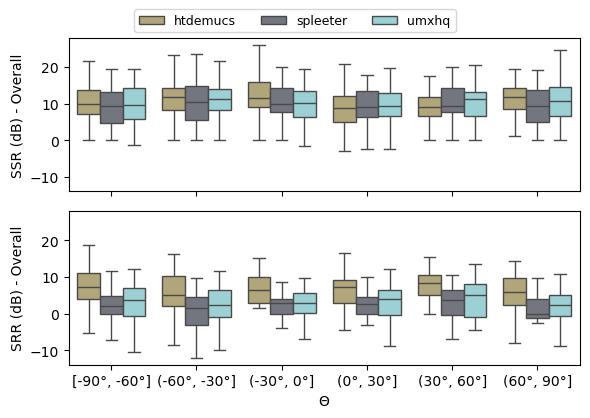

In [19]:
fig, ax = plt.subplots(2, 1, figsize=FIG_SIZE, tight_layout=True, sharex=True, sharey=True)

sns.boxplot(x='bins_ordered', y='SSR', hue='model', data=merged_df, ax=ax[0], palette=MODEL_PALETTE, showfliers=OUTLIERS)
sns.boxplot(x='bins_ordered', y='SRR', hue='model', data=merged_df, ax=ax[1], palette=MODEL_PALETTE, showfliers=OUTLIERS)

for a in ax:
    a.legend().remove()

h, l = ax[0].get_legend_handles_labels()

ax[0].set(ylabel='SSR (dB) - Overall', xlabel='$\Theta$')
ax[1].set(ylabel='SRR (dB) - Overall', xlabel='$\Theta$')

fig.legend(h, l, loc='upper center', fontsize=9, ncols=3, bbox_to_anchor=(0.5, 1.05))
plt.savefig(os.path.join(PLOT_DIR, 'spauq_model_angle.pdf'), bbox_inches='tight')
plt.show()

### By Angle (Overall by Source)

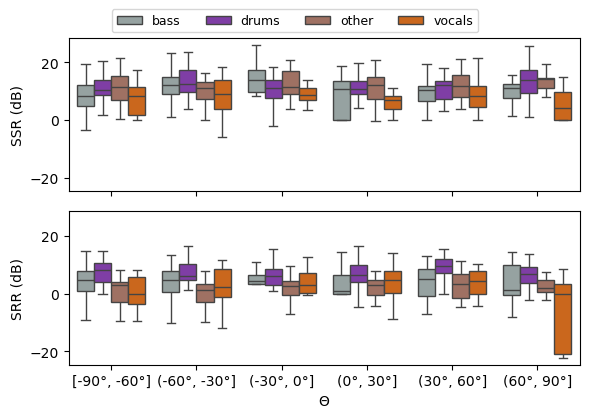

In [20]:
fig, ax = plt.subplots(2, 1, figsize=FIG_SIZE, tight_layout=True, sharex=True, sharey=True)

sns.boxplot(x='bins_ordered', y='SSR', hue='source', data=merged_df, palette=STEM_PALETTE, ax=ax[0], showfliers=OUTLIERS)
sns.boxplot(x='bins_ordered', y='SRR', hue='source', data=merged_df, palette=STEM_PALETTE, ax=ax[1], showfliers=OUTLIERS)

h, l = ax[0].get_legend_handles_labels()

for a in ax:
    a.legend().remove()

ax[0].set(ylabel='SSR (dB)', xlabel='$\Theta$')
ax[1].set(ylabel='SRR (dB)', xlabel='$\Theta$')

fig.legend(h, l, loc='upper center', fontsize=9, ncols=4, bbox_to_anchor=(0.5, 1.05))
plt.savefig(os.path.join(PLOT_DIR, 'spauq_source_angle.pdf'), bbox_inches='tight')
plt.show()

### By Angle (Overall)

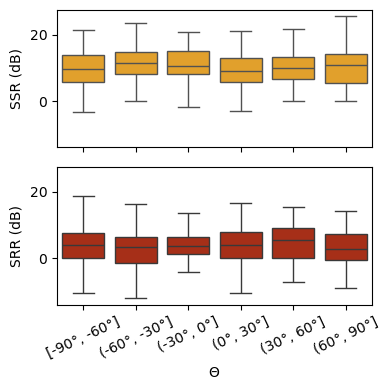

In [21]:
fig, ax = plt.subplots(2, 1, figsize=(4, 4), tight_layout=True, sharex=True, sharey=True)

sns.boxplot(x='bins_ordered', y='SSR', color=COLORS[1], data=merged_df, ax=ax[0], showfliers=OUTLIERS)
sns.boxplot(x='bins_ordered', y='SRR', color=COLORS[2], data=merged_df, ax=ax[1], showfliers=OUTLIERS)

ax[0].set(ylabel='SSR (dB)', xlabel='$\Theta$')
ax[1].set(ylabel='SRR (dB)', xlabel='$\Theta$')

ax[1].tick_params(axis='x', rotation=25)

plt.savefig(os.path.join(PLOT_DIR, 'spauq_source_angle.pdf'), bbox_inches='tight')
plt.show()

In [22]:
spauq_angle_df = merged_df.copy()

## Interaural Time Difference (ITD) & Interaural Level Difference (ILD)

In [23]:
SHOW_FLIERS_ITD = False
SHOW_FLIERS_ILD = False

### Data

In [24]:
ht_random_df = pd.read_csv('../data/eval/sh_metrics/itd_ild_2025-06-26_htdemucs_ft_random.csv')
ht_stereo_df = pd.read_csv('../data/eval/sh_metrics/itd_ild_2025-06-26_htdemucs_ft_stereo.csv')

spleet_random_df = pd.read_csv('../data/eval/sh_metrics/itd_ild_2025-06-26_spleeter_test_random.csv')
spleet_stereo_df = pd.read_csv('../data/eval/sh_metrics/itd_ild_2025-06-26_spleeter_test_stereo.csv')

umx_random_df = pd.read_csv('../data/eval/sh_metrics/itd_ild_2025-06-26_umxhq_random.csv')
umx_stereo_df = pd.read_csv('../data/eval/sh_metrics/itd_ild_2025-06-26_umxhq_stereo.csv')

In [25]:
ht_random_df['dataset'] = 'htdemucs_binaural'
ht_stereo_df['dataset'] = 'htdemucs_stereo'

spleet_random_df['dataset'] = 'spleeter_binaural'
spleet_stereo_df['dataset'] = 'spleeter_stereo'

umx_random_df['dataset'] = 'umxhq_binaural'
umx_stereo_df['dataset'] = 'umxhq_stereo'

In [26]:
htdemucs_df = pd.concat([ht_random_df, ht_stereo_df], ignore_index=True)
spleet_df = pd.concat([spleet_random_df, spleet_stereo_df], ignore_index=True)
umx_df = pd.concat([umx_random_df, umx_stereo_df], ignore_index=True)

In [27]:
all_models = pd.concat([htdemucs_df, spleet_df, umx_df], ignore_index=True)

In [28]:
all_models['model'] = all_models['dataset'].apply(lambda x: x.split('_')[0])
all_models['dataset'] = all_models['dataset'].apply(lambda x: x.split('_')[-1])

### By Model (Overall)

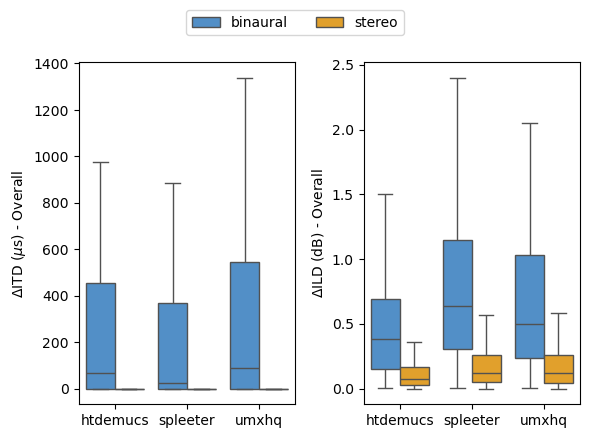

In [29]:
fig, axs = plt.subplots(1, 2, figsize=FIG_SIZE, tight_layout=True)
sns.boxplot(x='model', y='diff_ITD', hue='dataset', data=all_models, ax=axs[0], palette=DATASET_PALETTE, showfliers=OUTLIERS)
sns.boxplot(x='model', y='diff_ILD', hue='dataset', data=all_models, ax=axs[1], palette=DATASET_PALETTE, showfliers=OUTLIERS)

axs[0].set(ylabel='$\Delta$ITD ($\mu$s) - Overall', xlabel='')
axs[1].set(ylabel='$\Delta$ILD (dB) - Overall', xlabel='')

h, l = axs[0].get_legend_handles_labels()
l = ['binaural', 'stereo']

for a in axs:
    a.legend().remove()

fig.legend(h, l, loc='upper center', fontsize=10, ncols=3, bbox_to_anchor=(0.5, 1.1))
plt.savefig(os.path.join(PLOT_DIR, 'itdild_model_overall.pdf'), bbox_inches='tight')
plt.show()

### By Model (By Source)

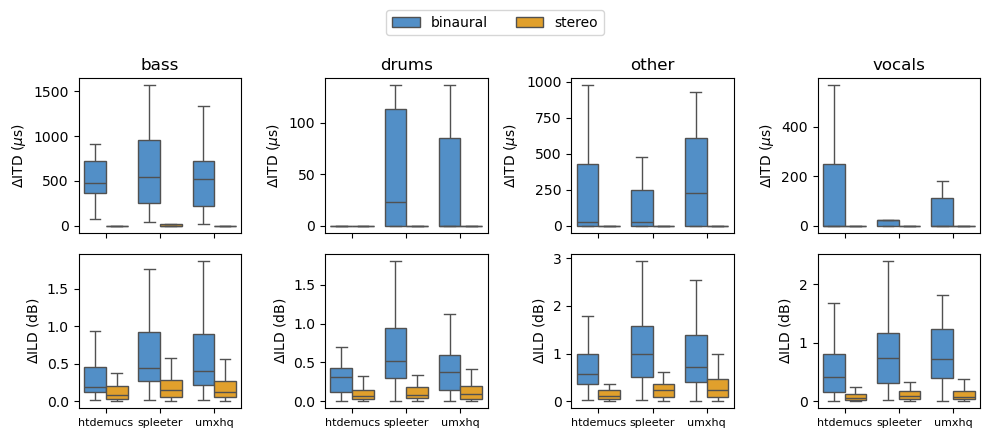

In [30]:
fig, axs = plt.subplots(2, 4, figsize=(10, 4), tight_layout=True, sharex=True)

x_labels = ['htdemucs', 'spleeter', 'umxhq']

for i in range(len(STEMS)):
    stem_df = all_models[all_models['source'] == STEMS[i]]
    
    sns.boxplot(x='model', y='diff_ITD', hue='dataset', data=stem_df, ax=axs[0][i], palette=DATASET_PALETTE, showfliers=OUTLIERS)
    sns.boxplot(x='model', y='diff_ILD', hue='dataset', data=stem_df, ax=axs[1][i], palette=DATASET_PALETTE, showfliers=OUTLIERS)
    
    axs[0][i].set(ylabel='$\Delta$ITD ($\mu$s)', xlabel='')
    axs[1][i].set(ylabel='$\Delta$ILD (dB)', xlabel='')
    axs[0][i].set_title(STEMS[i])

    axs[1][i].set_xticks(x_labels)
    axs[1][i].set_xticklabels(x_labels, fontsize=8)

h, l = axs[0][0].get_legend_handles_labels()
l = ['binaural', 'stereo']

for ax in axs.flatten():
    ax.legend().remove()

fig.legend(h, l, loc='upper center', fontsize=10, ncols=3, bbox_to_anchor=(0.5, 1.1))
plt.savefig(os.path.join(PLOT_DIR, 'itdild_model_source.pdf'), bbox_inches='tight')
plt.show()

### Angle Bins

In [31]:
OUTLIERS = False
FIG_SIZE = (6, 4)

In [32]:
metadata = pd.read_csv('../data/binaural_musdb18/metadata.csv', index_col=0)
metadata.rename(columns={'standard_angle': 'standard', 'random_angle': 'binaural'}, inplace=True)
metadata = metadata.melt(id_vars=['title', 'source'], var_name='dataset', value_name='angle')

In [33]:
merged_df = pd.merge(metadata, all_models, how='inner')
b = np.arange(-90, 91, 30)

# use these labels if you want the direction of the x-axis to match the physical placement
# b_labels = ['[-60°, -90°]', '[-30°, -60°)', '[0°, -30°)', '[30°, 0°)', '[60°, 30°)', '[90°, 60°)']

b_labels = ['[-90°, -60°]', '(-60°, -30°]', '(-30°, 0°]', '(0°, 30°]', '(30°, 60°]', '(60°, 90°]']
merged_df['bins_ordered'] = pd.cut(merged_df['angle'], bins=b, include_lowest=True, labels=b_labels)

# reorder if you want the direction of the x-axis to match the physical placement
# merged_df['bins_ordered'] = merged_df.bins.cat.reorder_categories(merged_df.bins.cat.categories[::-1], ordered=True)

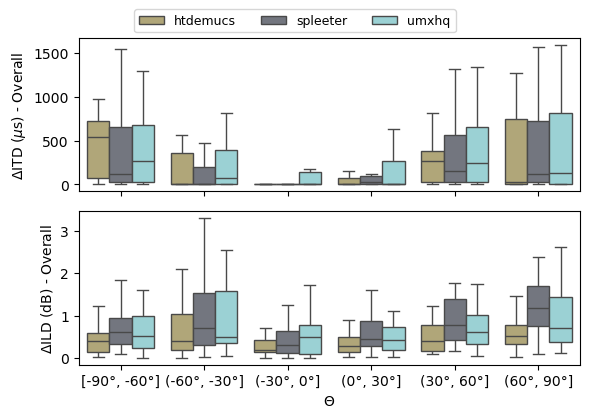

In [34]:
fig, axs = plt.subplots(2, 1, figsize=FIG_SIZE, tight_layout=True, sharex=True, sharey=False)

sns.boxplot(x='bins_ordered', y='diff_ITD', hue='model', data=merged_df, ax=axs[0], palette=MODEL_PALETTE, showfliers=OUTLIERS)
sns.boxplot(x='bins_ordered', y='diff_ILD', hue='model', data=merged_df, ax=axs[1], palette=MODEL_PALETTE, showfliers=OUTLIERS)

h, l = axs[0].get_legend_handles_labels()

for ax in axs:
    ax.legend().remove()

axs[0].set(ylabel='$\Delta$ITD ($\mu$s) - Overall', xlabel='$\Theta$')
axs[1].set(ylabel='$\Delta$ILD (dB) - Overall', xlabel='$\Theta$')

fig.legend(h, l, loc='upper center', fontsize=9, ncols=3, bbox_to_anchor=(0.5, 1.05))
plt.savefig(os.path.join(PLOT_DIR, 'itdild_model_angle.pdf'), bbox_inches='tight')
plt.show()

### By Angle (Overall by Source)

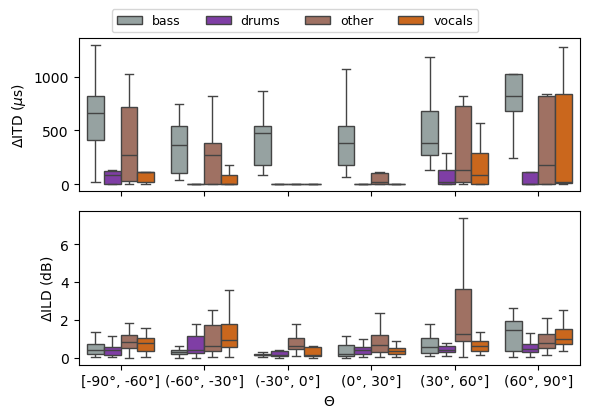

In [35]:
fig, axs = plt.subplots(2, 1, figsize=FIG_SIZE, tight_layout=True, sharex=True, sharey=False)

sns.boxplot(x='bins_ordered', y='diff_ITD', hue='source', data=merged_df, palette=STEM_PALETTE, ax=axs[0], showfliers=OUTLIERS)
sns.boxplot(x='bins_ordered', y='diff_ILD', hue='source', data=merged_df, palette=STEM_PALETTE, ax=axs[1], showfliers=OUTLIERS)

h, l = axs[0].get_legend_handles_labels()

for ax in axs:
    ax.legend().remove()

axs[0].set(ylabel='$\Delta$ITD ($\mu$s)', xlabel='$\Theta$')
axs[1].set(ylabel='$\Delta$ILD (dB)', xlabel='$\Theta$')

fig.legend(h, l, loc='upper center', fontsize=9, ncols=4, bbox_to_anchor=(0.5, 1.05))
plt.savefig(os.path.join(PLOT_DIR, 'itdild_source_angle.pdf'), bbox_inches='tight')
plt.show()

### By Angle (Overall)

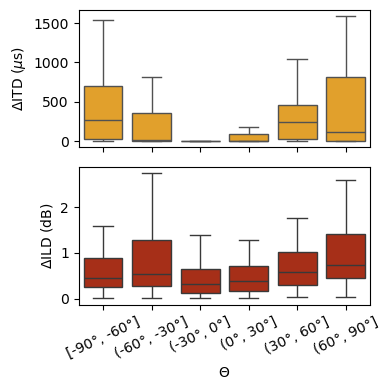

In [36]:
fig, ax = plt.subplots(2, 1, figsize=(4, 4), tight_layout=True, sharex=True, sharey=False)

sns.boxplot(x='bins_ordered', y='diff_ITD', color=COLORS[1], data=merged_df, ax=ax[0], showfliers=OUTLIERS)
sns.boxplot(x='bins_ordered', y='diff_ILD', color=COLORS[2], data=merged_df, ax=ax[1], showfliers=OUTLIERS)

ax[0].set(ylabel='$\Delta$ITD ($\mu$s)', xlabel='$\Theta$')
ax[1].set(ylabel='$\Delta$ILD (dB)', xlabel='$\Theta$')

ax[1].tick_params(axis='x', rotation=25)

plt.savefig(os.path.join(PLOT_DIR, 'itdild_angle.pdf'), bbox_inches='tight')
plt.show()

In [37]:
delta_angle_df = merged_df.copy()

## All Spatial Metrics

In [38]:
all_spatial = pd.merge(spauq_angle_df, delta_angle_df, how='inner')

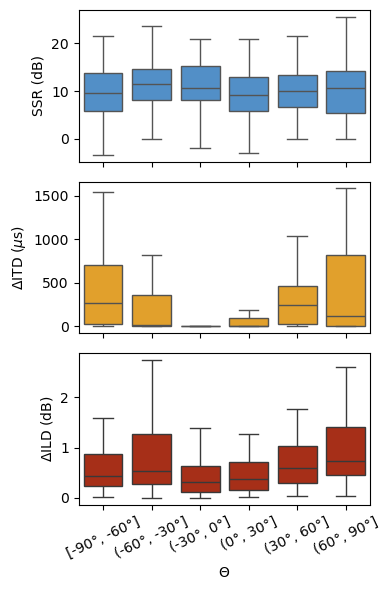

In [39]:
fig, ax = plt.subplots(3, 1, figsize=(4, 6), tight_layout=True, sharex=True, sharey=False)

sns.boxplot(x='bins_ordered', y='SSR', color=COLORS[0], data=all_spatial, ax=ax[0], showfliers=OUTLIERS)
sns.boxplot(x='bins_ordered', y='diff_ITD', color=COLORS[1], data=all_spatial, ax=ax[1], showfliers=OUTLIERS)
sns.boxplot(x='bins_ordered', y='diff_ILD', color=COLORS[2], data=all_spatial, ax=ax[2], showfliers=OUTLIERS)

ax[0].set(ylabel='SSR (dB)', xlabel='$\Theta$')
ax[1].set(ylabel='$\Delta$ITD ($\mu$s)', xlabel='$\Theta$')
ax[2].set(ylabel='$\Delta$ILD (dB)', xlabel='$\Theta$')

ax[2].tick_params(axis='x', rotation=25)

plt.savefig(os.path.join(PLOT_DIR, 'spatial_angle.pdf'), bbox_inches='tight')
plt.show()

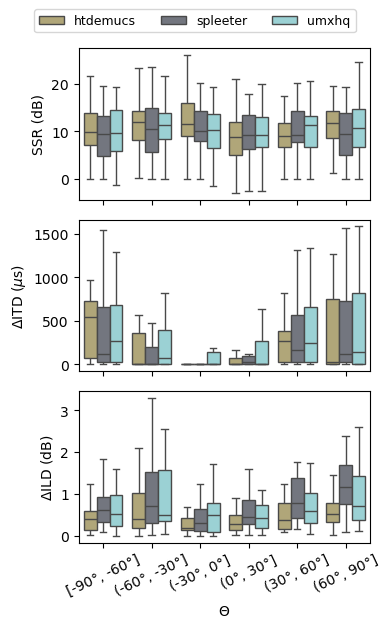

In [40]:
fig, ax = plt.subplots(3, 1, figsize=(4, 6), tight_layout=True, sharex=True, sharey=False)

sns.boxplot(x='bins_ordered', y='SSR', hue='model', palette=MODEL_PALETTE, data=all_spatial, ax=ax[0], showfliers=OUTLIERS)
sns.boxplot(x='bins_ordered', y='diff_ITD', hue='model', palette=MODEL_PALETTE, data=all_spatial, ax=ax[1], showfliers=OUTLIERS)
sns.boxplot(x='bins_ordered', y='diff_ILD', hue='model', palette=MODEL_PALETTE, data=all_spatial, ax=ax[2], showfliers=OUTLIERS)

h, l = ax[0].get_legend_handles_labels()

for a in ax:
    a.legend().remove()

ax[0].set(ylabel='SSR (dB)', xlabel='$\Theta$')
ax[1].set(ylabel='$\Delta$ITD ($\mu$s)', xlabel='$\Theta$')
ax[2].set(ylabel='$\Delta$ILD (dB)', xlabel='$\Theta$')

ax[2].tick_params(axis='x', rotation=25)

fig.legend(h, l, loc='upper center', fontsize=9, ncols=4, bbox_to_anchor=(0.5, 1.05))


plt.savefig(os.path.join(PLOT_DIR, 'spatial_angle_model.pdf'), bbox_inches='tight')
plt.show()